In [1]:
from predictor_syn import *

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [48]:
predictor = MNISTTransform(args=None)
class_list = [0,1,2,3,4,5,6,7,8,9]  #for large number of class we need more complex model
X1,Y1 = predictor.generate_dataset(num_examples=6000,
                            class_list=class_list,
                            transformation="rotation",
                            angle = np.pi*3.0/2.0,
)
# predictor.get_predictor(X1,Y1,class_list)

#Now getting the data from other domain
X2,Y2 = predictor.generate_dataset(num_examples=6000,
                            class_list=class_list,
                            transformation="rotation",
                            angle = 0,
)
#Now training the debugger
predictor.remove_spurious_features_unsup(X1,Y1,X2,Y2)

Total Number of examples in dataset: 60000
Number of Example after Subset: (58862, 28, 28, 1)
Total Number of examples in dataset: 60000
Number of Example after Subset: (58862, 28, 28, 1)
#################################################
###########  Training the Debugger ##############
#################################################
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 8)           0         
___________________________________________________

230/230 [==============================] - 3s 12ms/step - en_de_mse: 0.0118 - disc_loss: -0.6831 - disc_causal: -0.6930 - disc_spurious: 0.0100
Epoch 26/100
230/230 [==============================] - 3s 12ms/step - en_de_mse: 0.0117 - disc_loss: -0.6789 - disc_causal: -0.6931 - disc_spurious: 0.0142
Epoch 27/100
230/230 [==============================] - 3s 12ms/step - en_de_mse: 0.0113 - disc_loss: -0.6866 - disc_causal: -0.6931 - disc_spurious: 0.0065
Epoch 28/100
230/230 [==============================] - 3s 12ms/step - en_de_mse: 0.0112 - disc_loss: -0.6860 - disc_causal: -0.6931 - disc_spurious: 0.0071
Epoch 29/100
230/230 [==============================] - 3s 12ms/step - en_de_mse: 0.0109 - disc_loss: -0.6866 - disc_causal: -0.6931 - disc_spurious: 0.0065
Epoch 30/100
230/230 [==============================] - 3s 12ms/step - en_de_mse: 0.0117 - disc_loss: -0.6647 - disc_causal: -0.6931 - disc_spurious: 0.0284
Epoch 31/100
230/230 [==============================] - 3s 12ms/step - 

230/230 [==============================] - 3s 12ms/step - en_de_mse: 0.0082 - disc_loss: -0.6886 - disc_causal: -0.6921 - disc_spurious: 0.0035
Epoch 78/100
230/230 [==============================] - 3s 13ms/step - en_de_mse: 0.0079 - disc_loss: -0.6916 - disc_causal: -0.6931 - disc_spurious: 0.0016
Epoch 79/100
230/230 [==============================] - 3s 13ms/step - en_de_mse: 0.0080 - disc_loss: -0.6876 - disc_causal: -0.6931 - disc_spurious: 0.0054
Epoch 80/100
230/230 [==============================] - 3s 13ms/step - en_de_mse: 0.0078 - disc_loss: -0.6915 - disc_causal: -0.6931 - disc_spurious: 0.0016
Epoch 81/100
230/230 [==============================] - 3s 13ms/step - en_de_mse: 0.0078 - disc_loss: -0.6869 - disc_causal: -0.6931 - disc_spurious: 0.0062
Epoch 82/100
230/230 [==============================] - 3s 13ms/step - en_de_mse: 0.0078 - disc_loss: -0.6918 - disc_causal: -0.6931 - disc_spurious: 0.0013
Epoch 83/100
230/230 [==============================] - 3s 13ms/step - 

## Full Decoding

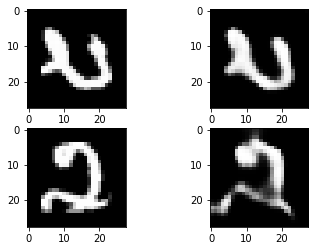

In [3]:
X = np.concatenate([X1,X2],axis=0)
rec_X1 = predictor.decoder(predictor.encoder(X)).numpy()
figure, axes = plt.subplots(2,2)

idx0 = 9423
axes[0,0].imshow(X[idx0,:,:,0],cmap="gray")
axes[0,1].imshow(rec_X1[idx0,:,:,0],cmap="gray")

idx1 = 19764
axes[1,0].imshow(X[idx1,:,:,0],cmap="gray")
axes[1,1].imshow(rec_X1[idx1,:,:,0],cmap="gray")

plt.show()

## Stable Decoding

In [49]:
def get_decoded_X(domain_X, domain_Y ,class_num):
    latent_space_dim = 7*7*2
    #Getting the encoded layer
    latent_X = predictor.encoder(domain_X).numpy()

    #Getting only causal latent representation
    only_causal_latent_X = latent_X.copy()
    only_causal_latent_X[:,latent_space_dim//2:] = 0

    #Getting only noise latent representation
    only_spurious_latent_X = latent_X.copy()
    only_spurious_latent_X[:,0:latent_space_dim//2] = 0 

    #Creading the causal feature for docding
    causal_X = predictor.decoder(only_causal_latent_X)
    spurious_X = predictor.decoder(only_spurious_latent_X)
    
    #Filtering for a particular class
    if class_num!=None:
        filter_arr = (domain_Y==class_num)
        
        domain_X = domain_X[filter_arr]
        causal_X = causal_X[filter_arr]
        spurious_X = spurious_X[filter_arr]
    
    return domain_X,causal_X,spurious_X

def plot_debugger_result(X1,Y1,X2,Y2,class_num):
    
    #Get the decoded data
    X1,causal_X1,spurious_X1 = get_decoded_X(X1,Y1,class_num)
    X2,causal_X2,spurious_X2 = get_decoded_X(X2,Y2,class_num)
    
    
    #Plotting the causal representation
    num_samples = 6
    figure, axes = plt.subplots(num_samples,6)

    imdxs = np.random.randint(0,causal_X1.shape[0],num_sample).tolist()
    for idx,imdx in enumerate(imdxs):
        axes[idx,0].imshow(X1[imdx,:,:,0],cmap="gray")
        axes[idx,1].imshow(causal_X1[imdx,:,:,0],cmap="gray")
        axes[idx,2].imshow(spurious_X1[imdx,:,:,0],cmap="gray")
        
        axes[idx,3].imshow(X2[imdx,:,:,0],cmap="gray")
        axes[idx,4].imshow(causal_X2[imdx,:,:,0],cmap="gray")
        axes[idx,5].imshow(spurious_X2[imdx,:,:,0],cmap="gray")
    plt.show()

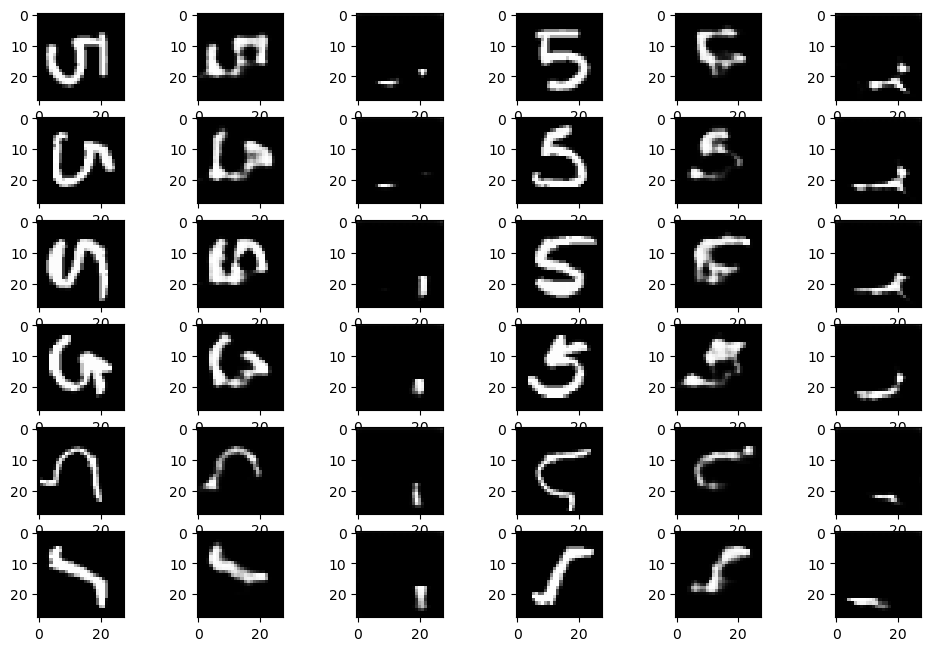

In [56]:
plot_debugger_result(X1,Y1,X2,Y2,5)